# Rock Classifier: #1 Image Cleaning
The aim of this series of notebooks is to experiment with different image classification models. I will use the images from Kaggle's [Rock Classification Dataset](https://www.kaggle.com/datasets/salmaneunus/rock-classification). 

This notebook will check the image quality and remove images which are duplicates and not rocks.

In [20]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load images
from PIL import Image
from skimage import img_as_float

In [21]:
DATA_DIR = "../img/Dataset/"
img_data = {}

for folder in os.listdir(DATA_DIR):
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]


## File type sanity check
Here I ensure all the images within the dataset are image files which can be read, so we don't run into any problems in the later analysis. The original folder has one additional layer which I manually removed:

- Metamorphic: Marble, Quartzite
- Igneous: Basalt, Granite
- Sedimentary: Coal, Limestone, Sandstone

In [3]:
for folder, img_list in img_data.items():
    counter = 0
    for path in img_list:
        try:
            im=Image.open(path)
        except IOError:
            print(f"Not an image: {path}")
    print(f"{counter} non-image files in {folder}")

0 non-image files in Basalt
0 non-image files in Coal
0 non-image files in Granite
0 non-image files in Limestone
0 non-image files in Marble
0 non-image files in Quartzite
0 non-image files in Sandstone


## Image dataset quality
Here I take a look at the sample of images available for each rock type to gain an understanding of the type of images the model will need to work with. After browsing the images, I noticed several challenges with the dataset which will require some preprocessing:

1. Questionable data quality - some images are not of rocks at all or I am doubtful that they are images of the stated rock type
2. Not all images are photographs, some are illustrations
3. Some images are combinations of several different images which might have been better split into individual images
4. Duplicated images (distorts the dataset's rock type distribution)

### Sample Images

Basalt


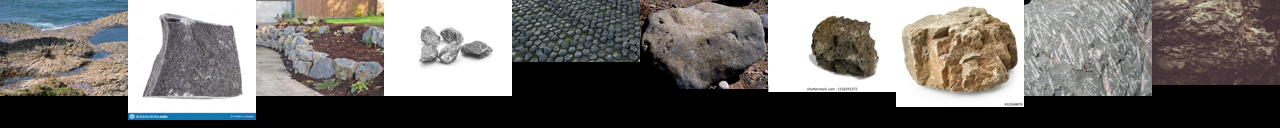

Coal


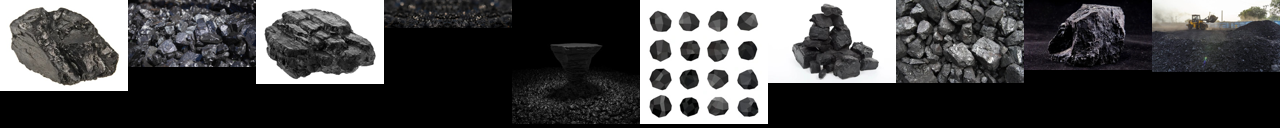

Granite


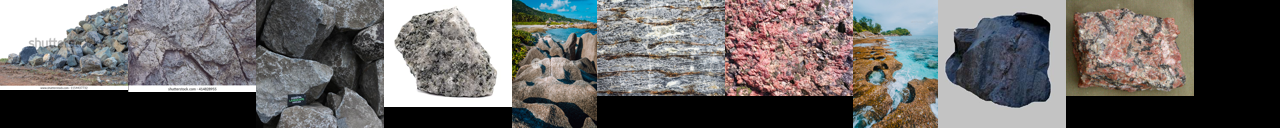

Limestone


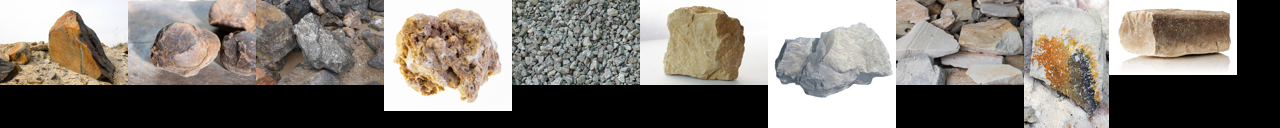

Marble


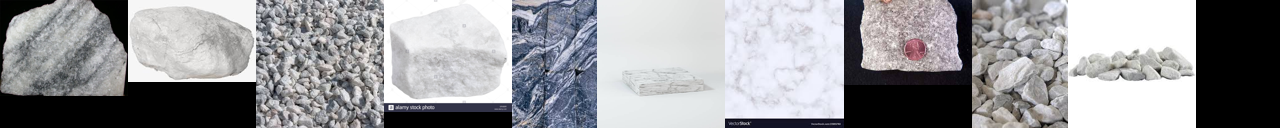

Quartzite


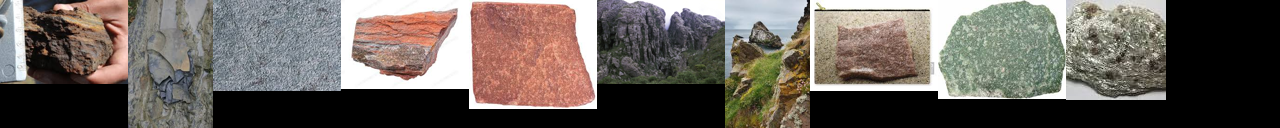

Sandstone


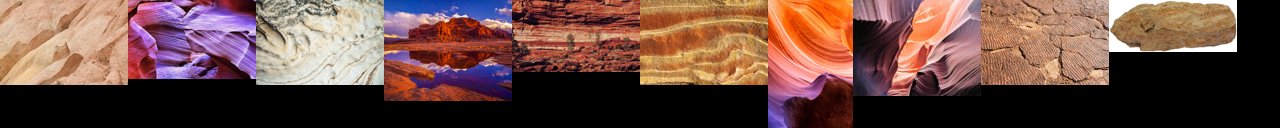

In [4]:
for i, folder in enumerate(img_data.keys()):
  print(folder)
  sample_size = 10
  images = [Image.open(x) for x in random.sample(img_data[folder], sample_size)]

  im_size = 128
  new_im = Image.new('RGB', (im_size*sample_size, im_size))

  x_offset = 0
  for im in images:
    im.thumbnail((im_size,im_size))
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  display(new_im)

## Data cleaning
With a dataset of this size, it would not take an absurd amount of time to manually go through all the images and select those of the correct quality. However, since this project is a learning opportunity I will attempt to algorithmically remove problematic images.

### Removing duplicate images
From observation, `limestone` has many visible duplicates, so I calibrated the sensitivity of the algorithm to remove duplicates using this. Then, I display all duplicates I remove to minimise errors. This is possible because the dataset is relatively small, but worth it because the task is menial.

Images are a 2D matrix of pixels. The colour of each pixel is represented by three numbers which denote the percentage of red, green and blue. A duplicated image will have the same pixels as the original image which means we could find the difference between each image, pixel by pixel. If two images have a very low difference, we can say that they are duplicates. This method is called **Mean Squared Error (MSE)** because that is exactly what is being calculated between each pair of images.

In [5]:
def load_image(path, size=(256,256)):
    """
    Convert image to float
    
    Input:
    path(str): Path to image file
    size(tuple): Resize image

    Output:
    (array): 256x256x3 image, all values float between 0 and 1
    """
    img = Image.open(path)
    img = img.convert('RGB')
    img = img.resize(size)
    return img_as_float(img)

In [6]:
def mse(img1, img2):
    err = np.sum((img1 - img2) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

In [7]:
img_list = img_data['Limestone']
mse_mat = np.full((len(img_list), len(img_list)), np.inf)

for i, img_path1 in enumerate(img_list[:-1]):
    img1 = load_image(img_path1)
    for k, img_path2 in enumerate(img_list[i+1:]):
        img2 = load_image(img_path2)
        mse_mat[i,k+i+1] = mse(img1, img2)

The MSE is close to zero for most pairs of images most likely because many of them have white background and limestone rocks are similar in colour.

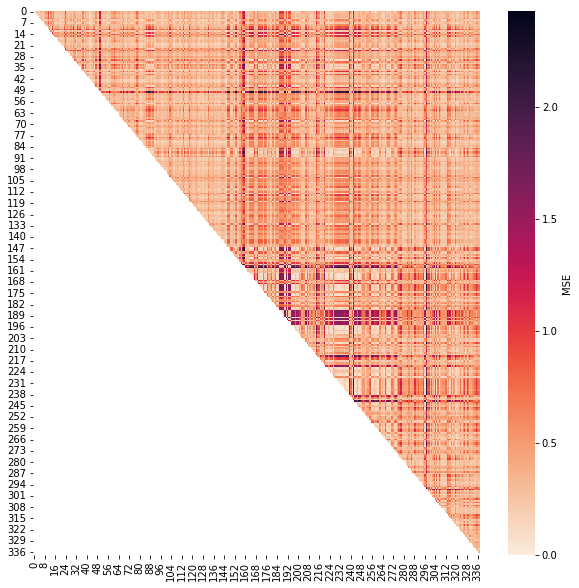

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = sns.heatmap(mse_mat, mask=np.tril(mse_mat), cmap=sns.cm.rocket_r)
cax.collections[0].colorbar.set_label("MSE")
plt.show()

If I take the MSE of a pair of images I know is a duplicate, I can have a benchmark for how the MSE should be for a duplicate image.

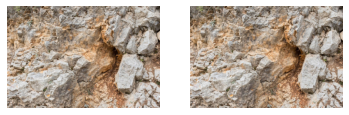

MSE: 0.0


In [9]:
im1_path = DATA_DIR+"/Limestone/46.jpg"
im2_path = DATA_DIR+"/Limestone/47.jpg"
fig, axarr = plt.subplots(1,2)
for ax, path in zip(axarr, [im1_path, im2_path]):
    ax.imshow(Image.open(path))
    ax.axis('off')
plt.show()

img1 = load_image(im1_path)
img2 = load_image(im2_path)
print(f"MSE: {mse(img1, img2)}")

These two images are the same, but the scaling is different.

(250, 250)
(500, 500)


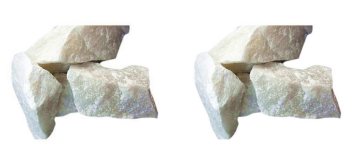

MSE: 0.0007714916494707564


In [10]:
im1_path = DATA_DIR+"/Limestone/36.jpg"
im2_path = DATA_DIR+"/Limestone/37.jpg"
fig, axarr = plt.subplots(1,2)
for ax, path in zip(axarr, [im1_path, im2_path]):
    im = Image.open(path)
    print(im.size)
    ax.imshow(im)
    ax.axis('off')
plt.show()

img1 = load_image(im1_path)
img2 = load_image(im2_path)
print(f"MSE: {mse(img1, img2)}")

Based on this MSE, I will benchmark the threshold MSE for a duplicate image to be within the same order of magnitude.

In [11]:
threshold = 0.001
dup_images = list(set(np.concatenate(np.where(mse_mat<threshold))))
print(f"Number images with duplicates: {len(dup_images)}")

Number images with duplicates: 39


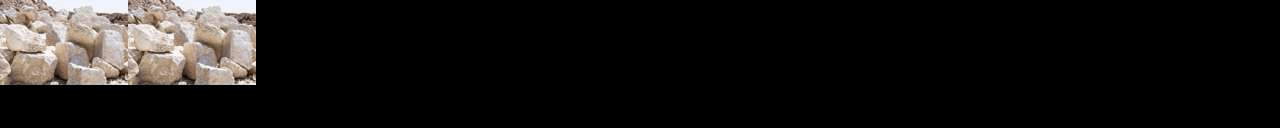

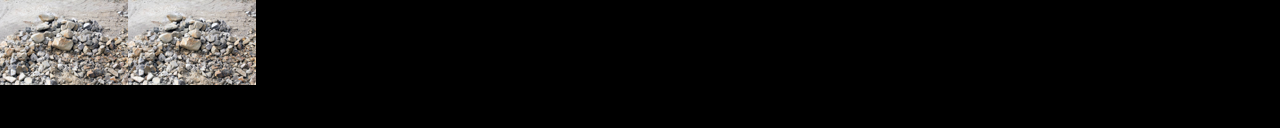

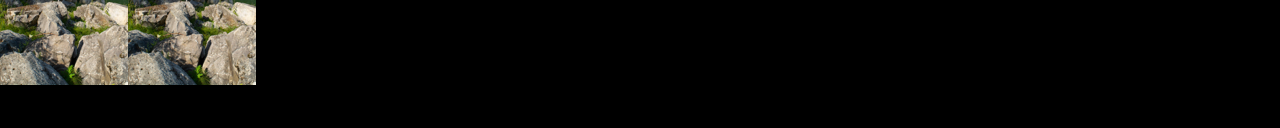

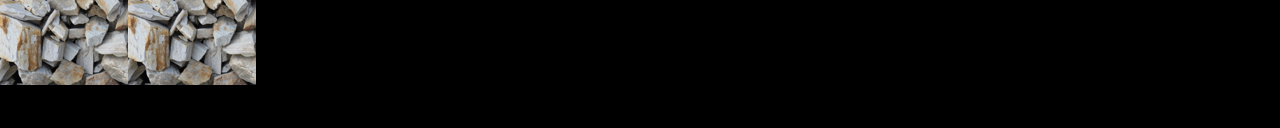

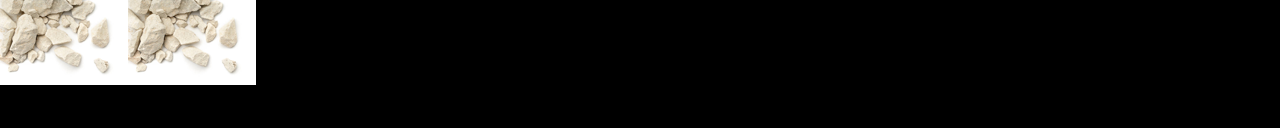

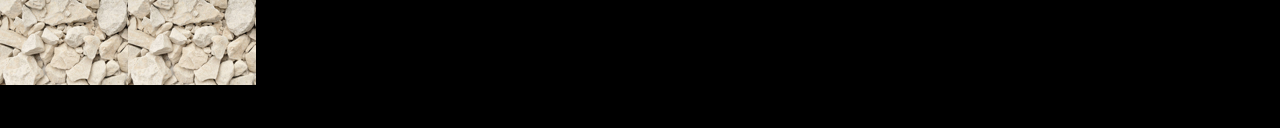

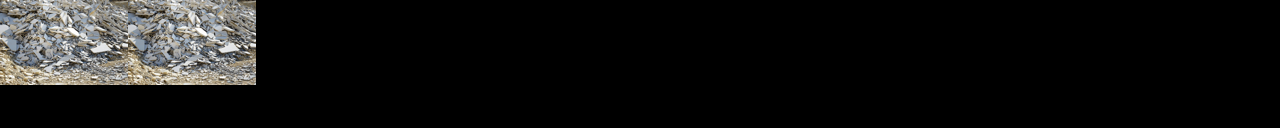

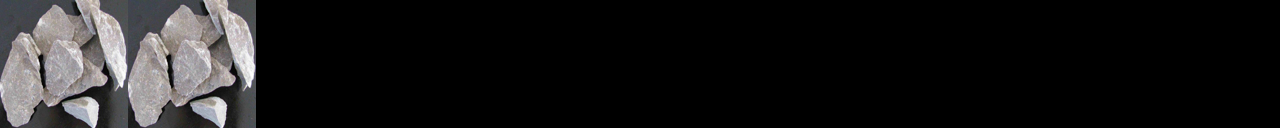

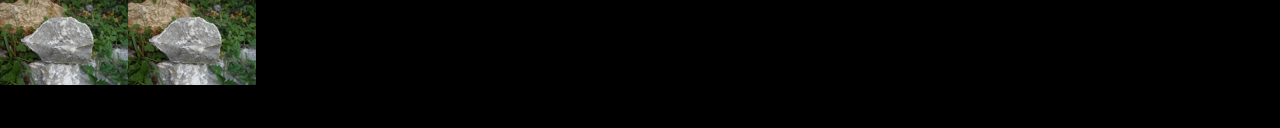

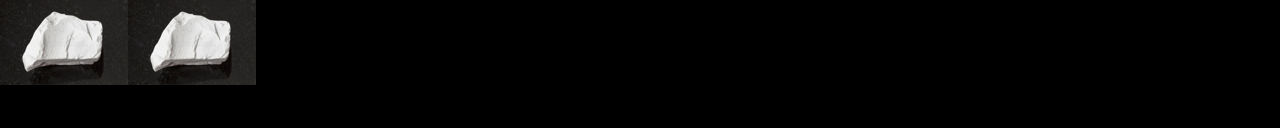

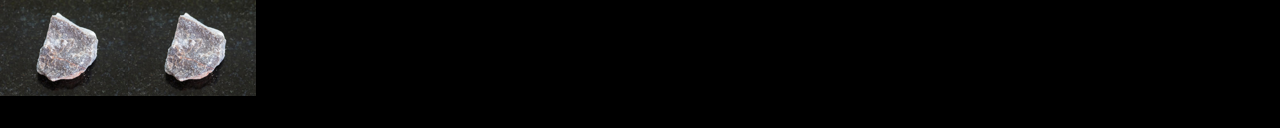

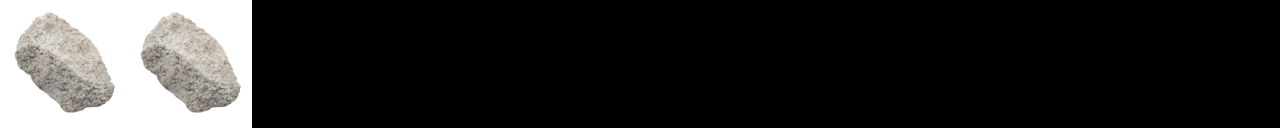

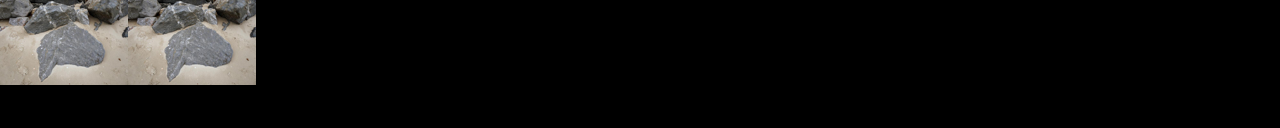

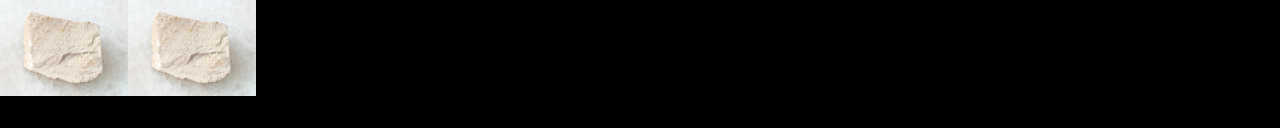

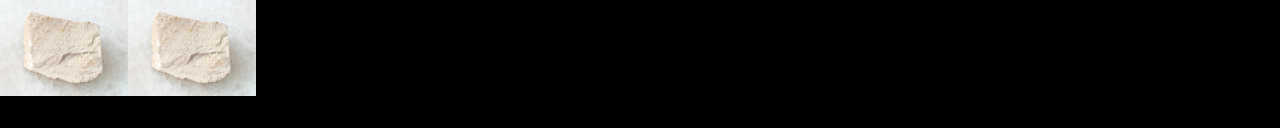

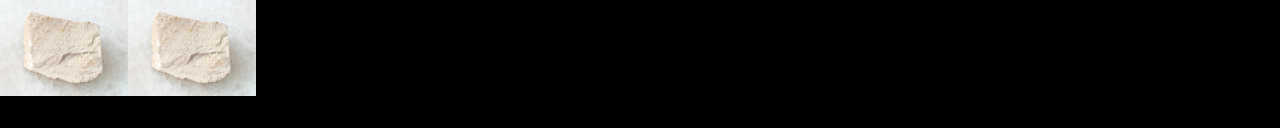

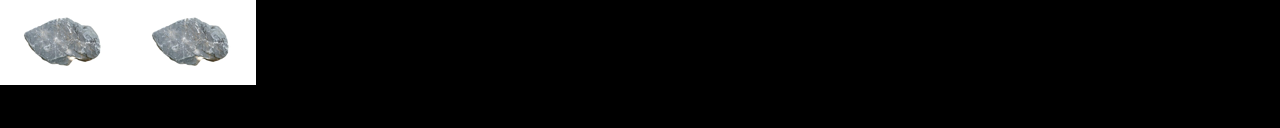

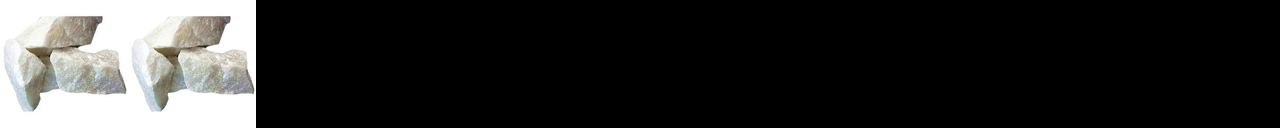

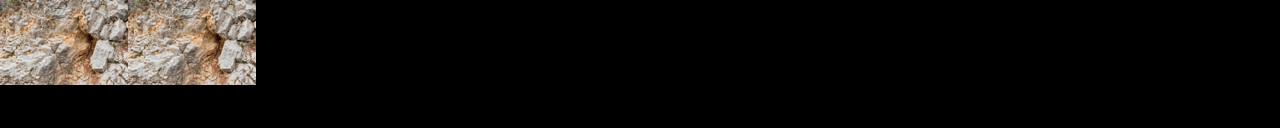

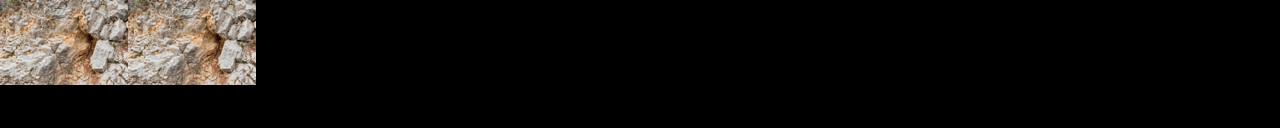

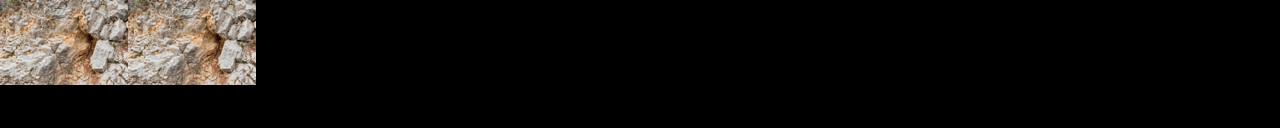

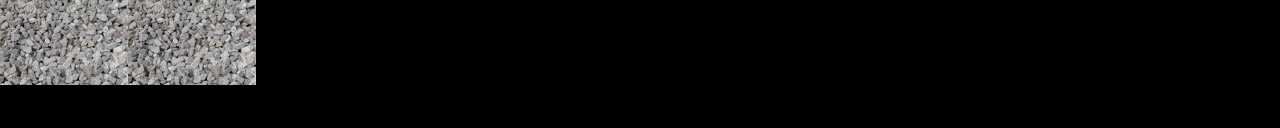

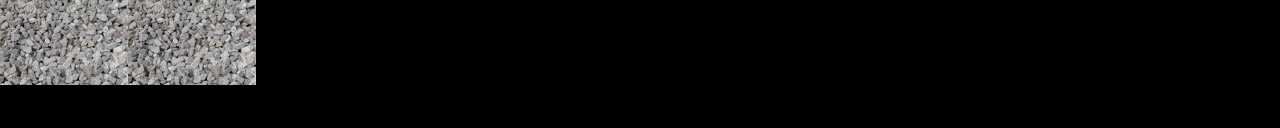

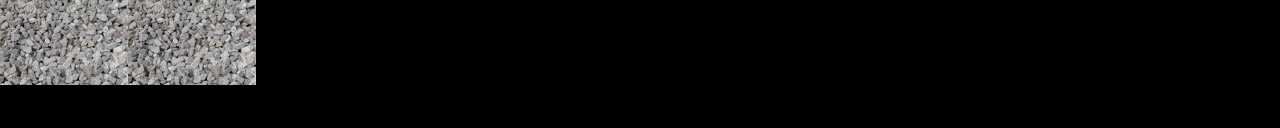

In [12]:
for i, k in list(zip(*np.where(mse_mat<threshold))):
  im_size = 128
  new_im = Image.new('RGB', (im_size*sample_size, im_size))

  x_offset = 0
  for im in [Image.open(img_list[i]), Image.open(img_list[k])]:
    im.thumbnail((im_size,im_size))
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  display(new_im)

#### Comparing other methods of computing image similarity
There are other image similarity algorithms I could have chosen that better capture perceptual similarity. For example: 
- [skimage  `structural_similarity`](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)
- [OpenCV's `findHomography`](https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html)

However, the duplicates which concern me in the dataset are straightforward, literal copy-pasted images. Images that sort of look the same are fine I will perform some image augmentation before model training anyway. The goal of removing the duplicates is to have an accurate representation of rock type distribution, so we might better decide how to solve for class imbalance.

Since I introduced two other image similarity algorithms, I will compare the performance skimage's `structural_similarity` algorithm with MSE.

In [13]:
from skimage.metrics import structural_similarity as ssim

ssim_mat = np.zeros((len(img_list), len(img_list)))

for i, img_path1 in enumerate(img_list[:-1]):
    img1 = load_image(img_path1)
    for k, img_path2 in enumerate(img_list[i+1:]):
        img2 = load_image(img_path2)
        ssim_mat[i,k+i+1] = ssim(img1, img2, data_range=1, multichannel=True)

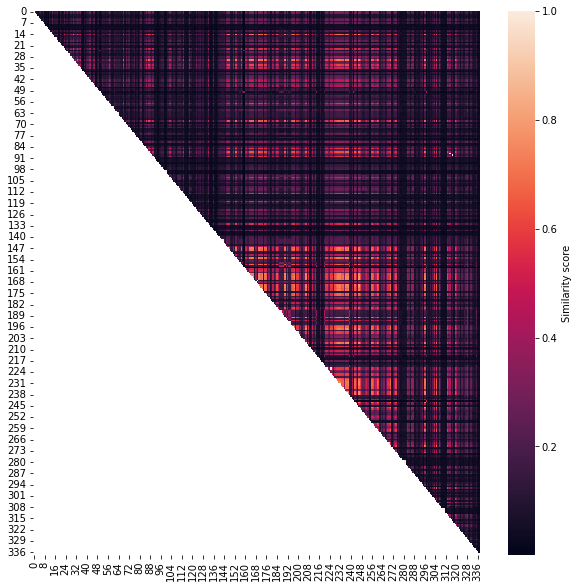

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
matrix = ssim_mat==0
cax = sns.heatmap(ssim_mat, mask=matrix)
cax.collections[0].colorbar.set_label("Similarity score")
plt.show()

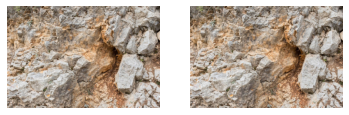

Structural similarity: 1.0


In [15]:
im1_path = DATA_DIR+"/Limestone/46.jpg"
im2_path = DATA_DIR+"/Limestone/47.jpg"
fig, axarr = plt.subplots(1,2)
for ax, path in zip(axarr, [im1_path, im2_path]):
    ax.imshow(Image.open(path))
    ax.axis('off')
plt.show()

img1 = load_image(im1_path)
img2 = load_image(im2_path)
print(f"Structural similarity: {ssim(img1, img2, data_range=1, multichannel=True)}")

(250, 250)
(500, 500)


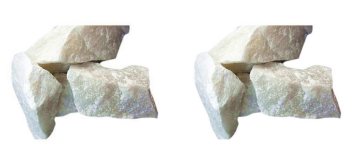

Structural similarity: 0.9571397751631188


In [16]:
im1_path = DATA_DIR+"/Limestone/36.jpg"
im2_path = DATA_DIR+"/Limestone/37.jpg"
fig, axarr = plt.subplots(1,2)
for ax, path in zip(axarr, [im1_path, im2_path]):
    im = Image.open(path)
    print(im.size)
    ax.imshow(im)
    ax.axis('off')
plt.show()

img1 = load_image(im1_path)
img2 = load_image(im2_path)
print(f"Structural similarity: {ssim(img1, img2, data_range=1, multichannel=True)}")

Just like with MSE, I will benchmark the structural similarity threshold based on the resized image.

In [17]:
dup_images = list(set(np.concatenate(np.where(ssim_mat>0.9))))
print(f"Number images with duplicates: {len(dup_images)}")

Number images with duplicates: 39


Both have identified the same duplicate images!

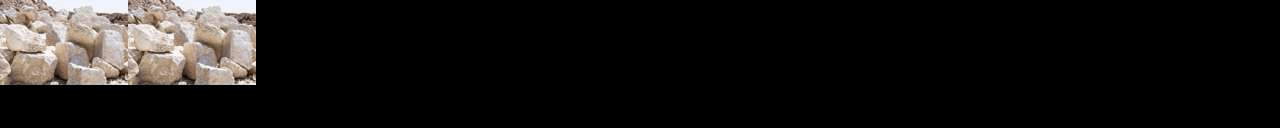

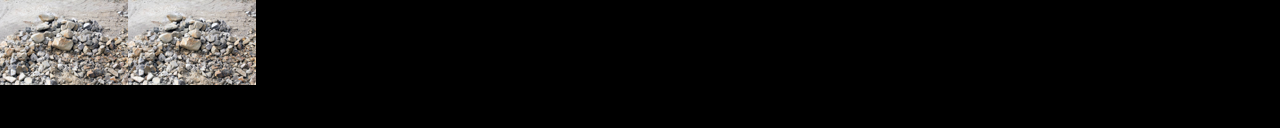

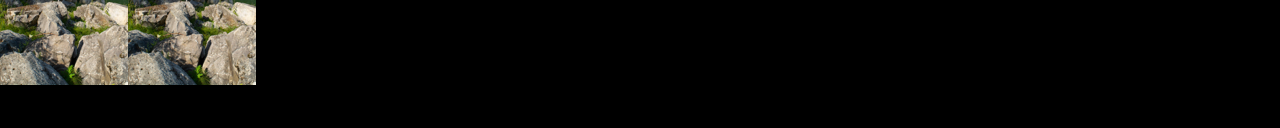

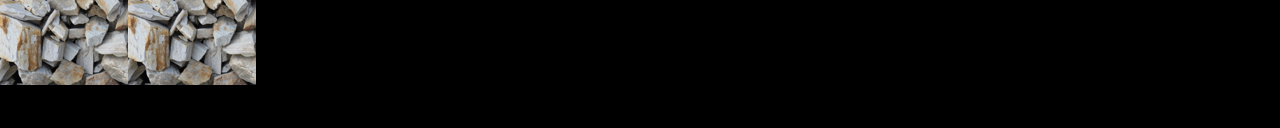

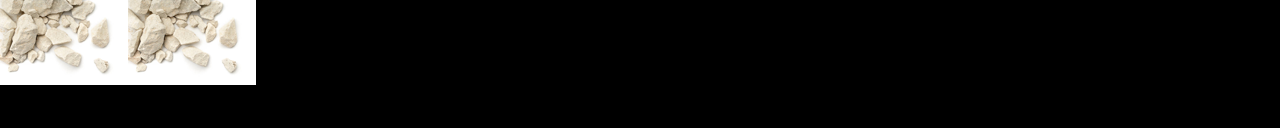

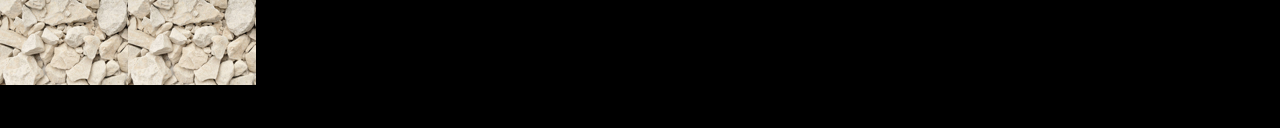

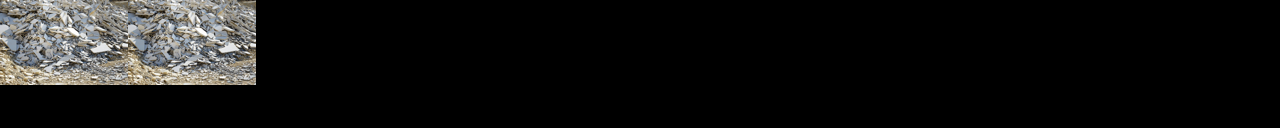

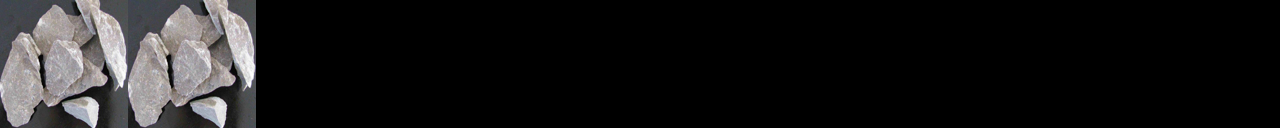

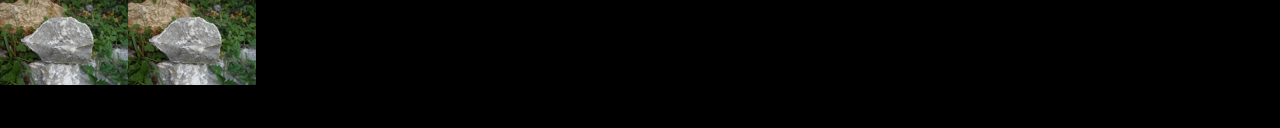

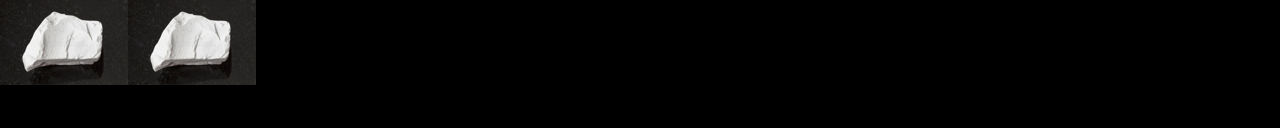

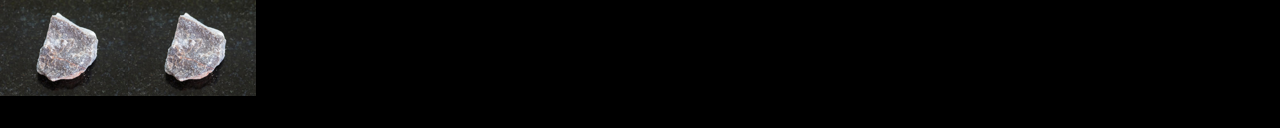

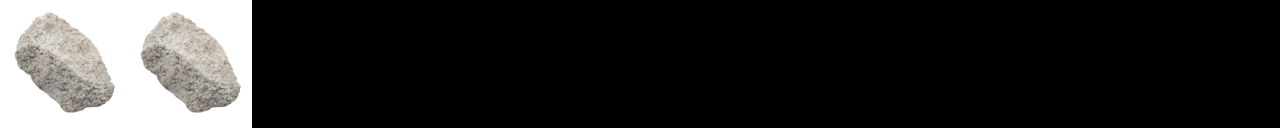

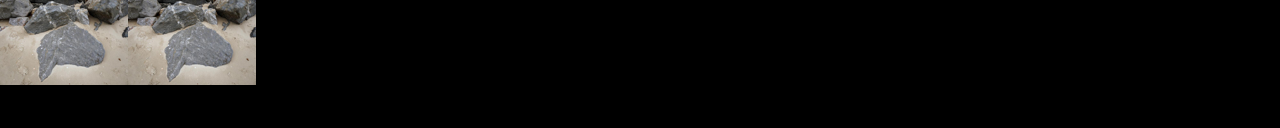

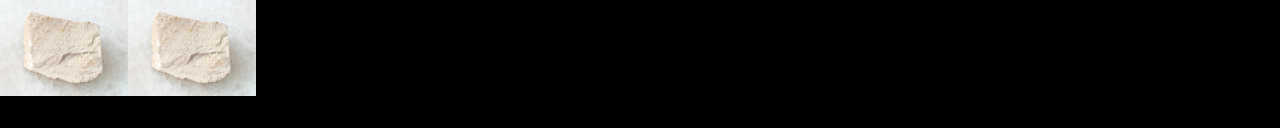

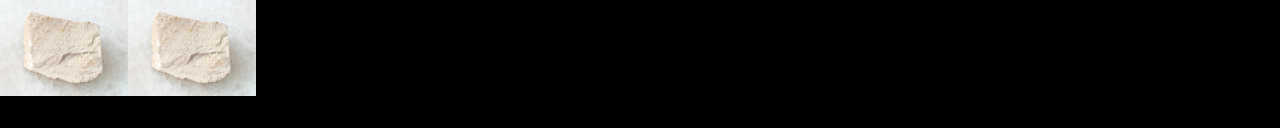

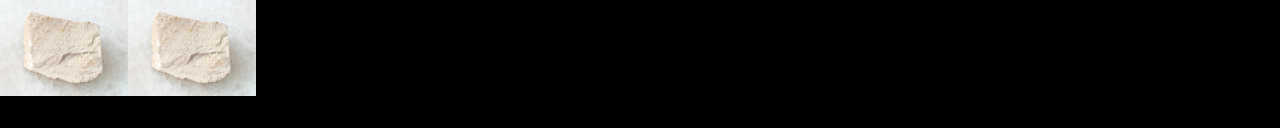

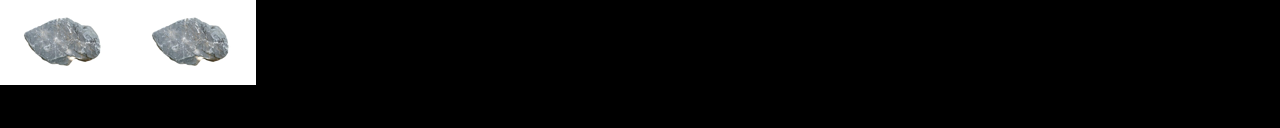

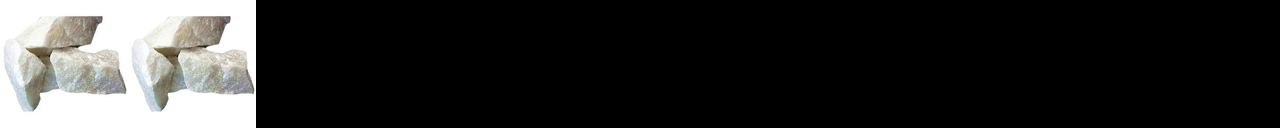

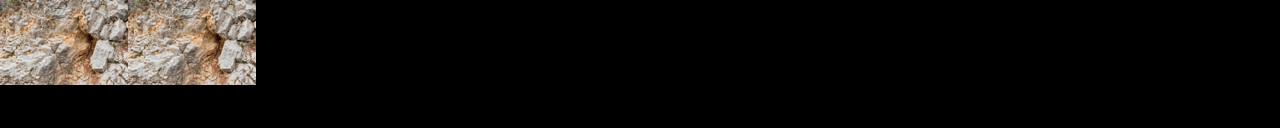

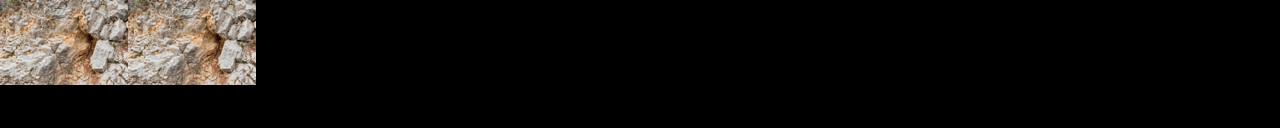

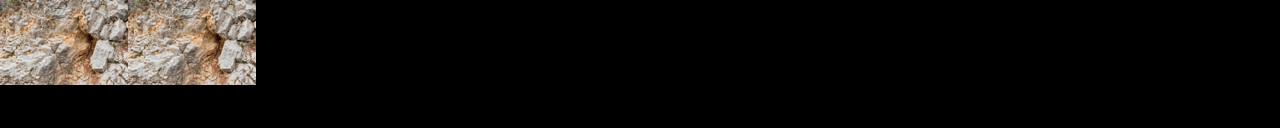

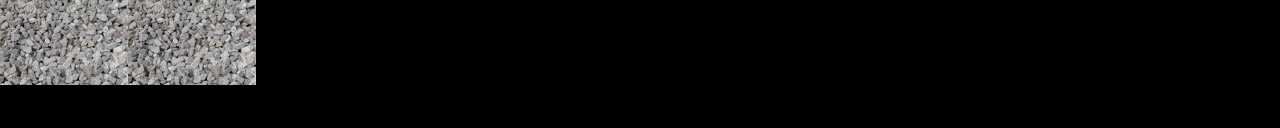

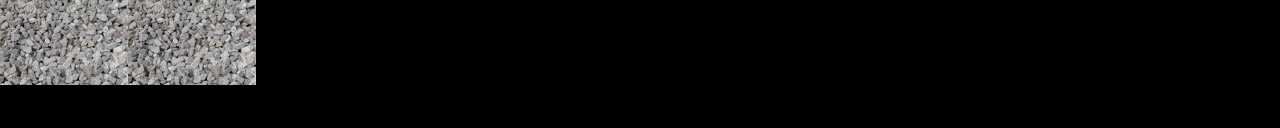

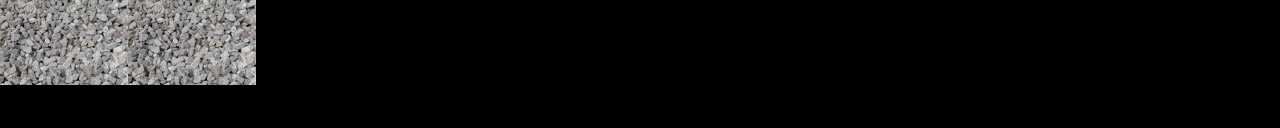

In [18]:
for i, k in list(zip(*np.where(ssim_mat>0.9))):
  im_size = 128
  new_im = Image.new('RGB', (im_size*sample_size, im_size))

  x_offset = 0
  for im in [Image.open(img_list[i]), Image.open(img_list[k])]:
    im.thumbnail((im_size,im_size))
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  display(new_im)

#### Removing image duplicates

In [19]:
dup_img_path = {}

for folder in img_data:
    img_list = img_data[folder]
    mse_mat = np.full((len(img_list), len(img_list)), np.inf)

    for i, img_path1 in enumerate(img_list[:-1]):
        img1 = load_image(img_path1)
        for k, img_path2 in enumerate(img_list[i+1:]):
            img2 = load_image(img_path2)
            mse_mat[i,k+i+1] = mse(img1, img2)

    ori_img_idx = []
    dup_img_idx = []
    dup_img_path[folder] = []

    # Get index of duplicate image
    for i, k in list(zip(*np.where(mse_mat<threshold))):
        if i not in ori_img_idx and i not in dup_img_idx:
            ori_img_idx.append(i)
            dup_img_idx.append(k)
            dup_img_path[folder].append(img_list[k])
        elif i in dup_img_idx:
            dup_img_path[folder].append(img_list[k])

In [20]:
import json 
with open('img/duplicate_img_path.json','w') as f:
    json.dump(dup_img_path, f)

## Dataset size
The rock type distribution does not change drastically after removing the duplicates. 

We have an imbalanced data set with significantly lower number of images for basalt and granite.

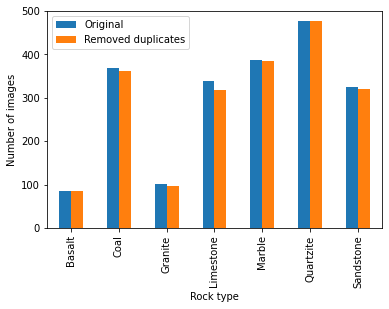

In [37]:
num_img = [len(v) for k,v in img_data.items()]
num_img_wo_dup = [len(v)-len(dup_img_path[k]) for k,v in img_data.items()]

df = pd.DataFrame(
    np.array([num_img, num_img_wo_dup]).T, 
    index=img_data.keys(),
    columns=['Original', 'Removed duplicates']
    )
ax = df.plot.bar()
ax.legend()
ax.set_ylabel('Number of images')
ax.set_xlabel('Rock type')
plt.show()

## Manual cleaning
I will remove the rest of the images manually. Here are the image paths I will remove and some reasonings behind my choice. 

- **Coal**: statues, parts of homes, parts of buildings, old photographs, 
- **Quartzite**: Rock is only a small portion of image (ie: text, other objects), images of cells, houses,
- **Sandstone**: Buildings

I was not sure whether to remove images with text at the forefront, but there are similar types of images in all the folders, so I erred on the side of caution and chose to keep them.

In [4]:
remove_img_path = {
    'Basalt': [],
    'Coal': [],
    'Granite': [],
    'Limestone':[],
    'Marble':[
        DATA_DIR + "Marble/1 (352).jpg",
        DATA_DIR + "Marble/1 (467).jpg",
        DATA_DIR + "Marble/1 (529).jpg",
        DATA_DIR + "Marble/1 (396).jpg",
        DATA_DIR + "Marble/1 (460).jpg",
        DATA_DIR + "Marble/1 (455).jpg",
        DATA_DIR + "Marble/1 (483).jpg",
        DATA_DIR + "Marble/1 (545).jpg",
        DATA_DIR + "Marble/1 (521).jpg",
        DATA_DIR + "Marble/1 (552).jpg",
        DATA_DIR + "Marble/1 (554).jpg",
        DATA_DIR + "Marble/1 (559).jpg",
        DATA_DIR + "Marble/istockphoto-92256869-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-184592313-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-484343309-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-1187562031-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-1132036755-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-694142286-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-182148999-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-125913888-612x612.jpg",
        DATA_DIR + "Marble/istockphoto-1049711572-612x612.jpg"     
    ],
    'Quartzite': [
        DATA_DIR + 'Quartzite/3-s2.0-B9780444639011000411-f41-11-9780444639011.jpg',
        DATA_DIR + 'Quartzite/3-s2.0-B9780444639011000411-f41-12-9780444639011.jpg',
        DATA_DIR + 'Quartzite/images(46).jpg',
        DATA_DIR + 'Quartzite/images(309).jpg',
        DATA_DIR + 'Quartzite/images(318).jpg',
        DATA_DIR + 'Quartzite/images(329).jpg',
        DATA_DIR + 'Quartzite/images(336).jpg',
        DATA_DIR + 'Quartzite/images(360).jpg',
        DATA_DIR + 'Quartzite/images(391).jpg',
        DATA_DIR + 'Quartzite/images(397).jpg',
        DATA_DIR + 'Quartzite/images(414).jpg',
        DATA_DIR + 'Quartzite/images(422).jpg',
        DATA_DIR + 'Quartzite/images(509).jpg',
        DATA_DIR + 'Quartzite/images(220).jpg',
        DATA_DIR + 'Quartzite/images(236).jpg'
    ],
    'Sandstone': [
        DATA_DIR + 'Sandstone/images(175).jpg',
        DATA_DIR + 'Sandstone/images(187).jpg',
        DATA_DIR + 'Sandstone/images(278).jpg',
    ]
}

In [5]:
with open('img/remove_img_path.json','w') as f:
    json.dump(remove_img_path, f)

The distribution doesn't change drastically here either but at least the data quality will be better.

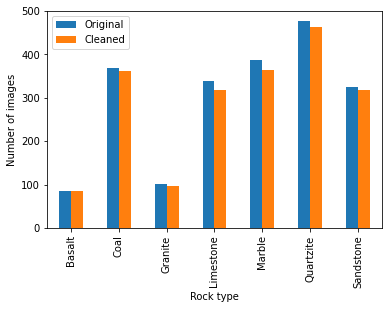

In [40]:
num_img = [len(v) for k,v in img_data.items()]
num_clean_img = [len(v)-len(dup_img_path[k])-len(remove_img_path[k]) for k,v in img_data.items()]

df = pd.DataFrame(
    np.array([num_img, num_clean_img]).T, 
    index=img_data.keys(),
    columns=['Original', 'Cleaned']
    )
ax = df.plot.bar()
ax.legend()
ax.set_ylabel('Number of images')
ax.set_xlabel('Rock type')
plt.show()

## Remove images

In [17]:
import json
with open('../img/remove_img_path.json', 'r') as f:
    remove_img_path = json.load(f)

with open('../img/duplicate_img_path.json', 'r') as f:
    dup_img_path = json.load(f)

In [22]:
for folder, path_list in dup_img_path.items():
    for path in path_list:
        if os.path.isfile(path):
            os.remove(path)
        else:    
            continue

In [23]:
for folder, path_list in remove_img_path.items():
    for path in path_list:
        if os.path.isfile(path):
            os.remove(path)
        else:    
            continue